In [1]:
import numpy as np
import csv
import tqdm
import matplotlib.pyplot as plt
import matplotlib.image as img
import matplotlib

import datasets

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

In [2]:
dataset_odn = datasets.C100Dataset('./dataset/data/cifar100.csv')
[tr_x, tr_y, ts_x, ts_y] = dataset_odn.getDataset()

turtle


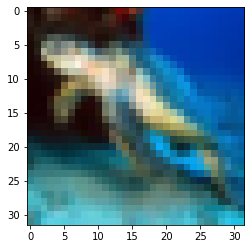

In [3]:
im_dir = './dataset/'
plt.imshow(img.imread(im_dir+tr_x[99]))
print(tr_y[99])

In [4]:
label = set(tr_y)
label = np.array(list(label))

In [5]:
def tr_val(x_, y_):
    mask = np.ones(len(x_))
    mask[:int(len(mask)/5)] = 0 # #1:#0 = 4:1
    np.random.shuffle(mask)
    x_tr, x_vl = x_[mask==1], x_[mask==0]
    y_tr, y_vl = y_[mask==1], y_[mask==0]
    return x_tr, x_vl, y_tr, y_vl
def batch_div(x_, y_, num):
    x_b, y_b = [], []
    mask = np.tile(np.arange(int(len(x_)/num)), num)
    np.random.shuffle(mask)
    for i in range (int(len(x_)/num)):
        x_b.append(x_[mask==i])
        y_b.append(y_[mask==i])
    return int(len(x_)/num), x_b, y_b

# VGGnet
<https://arxiv.org/pdf/1409.1556.pdf>

In [6]:
trainx = np.array([img.imread(im_dir+u).T for i,u in enumerate(tr_x)])
trainy = np.zeros([len(tr_y), 100], dtype='int32')
for i,u in enumerate(label):
    for j,v in enumerate(tr_y):
        if v==u: trainy[j][i] = 1
            
testx = np.array([img.imread(im_dir+u).T for i,u in enumerate(ts_x)])
testy = np.zeros([len(ts_y), 100], dtype='int32')
for i,u in enumerate(label):
    for j,v in enumerate(ts_y):
        if v==u: testy[j][i] = 1
trainx, testx = torch.FloatTensor(trainx), torch.FloatTensor(testx)
trainy, testy = torch.FloatTensor(trainy), torch.FloatTensor(testy)

In [9]:
class VGG(nn.Module):
    def __init__(self):
        super().__init__()
        self.pool = nn.MaxPool2d(2, 2)
        self.C1 = nn.Conv2d(3, 16, 3, 1, 1)
        self.C2 = nn.Conv2d(16, 32, 3, 1, 1)
        self.C3 = nn.Conv2d(32, 32, 3, 1, 1)
        self.C4 = nn.Conv2d(32, 32, 3, 1, 1)
        self.W1 = nn.Linear(32*8*8, 1024)
        self.W2 = nn.Linear(1024, 256)
        self.W3 = nn.Linear(256, 100)
        self.S = nn.Sigmoid()

    def forward(self, x):
        x = F.relu(self.C1(x))
        x = self.pool(F.relu(self.C2(x)))
        x = F.relu(self.C3(x))
        x = self.pool(F.relu(self.C4(x)))
        x = x.view(-1, 32*64)
        x = F.relu(self.W2(F.relu(self.W1(x))))
        x = self.S(self.W3(x))
        return x
    
def loss1(output, y):
    #regular = reg*(torch.norm(self.W1.weight.data, p=1)+torch.norm(self.W2.weight.data, p=1))
    return F.binary_cross_entropy(output, y)+regular
def loss2(output, y):
    #regular = reg*(torch.norm(self.W1.weight.data)**2+torch.norm(self.W2.weight.data)**2)
    return F.binary_cross_entropy(output, y)

def accuracy(output, y):
    return torch.sum(torch.argmax(output, axis=1)==torch.argmax(y, axis=1))

In [10]:
reg = 0
model = VGG()
optimizer = optim.Adam(model.parameters(), lr = 1e-3)
n_epochs = 20
x_tr, x_vl, y_tr, y_vl = tr_val(trainx, trainy)
tr_loss, vl_loss = np.zeros(n_epochs, dtype='float64'), np.zeros(n_epochs, dtype='float64')
tr_accy, vl_accy, ts_accy = np.zeros_like(tr_loss), np.zeros_like(tr_loss), np.zeros_like(tr_loss)

for epoch in range(n_epochs):
    losst = 0.
    accyt = 0
    batchnum, x_tr_b, y_tr_b = batch_div(x_tr, y_tr, 100)
    for i in range (batchnum):
        output = model.forward(x_tr_b[i])
        loss = loss2(output, y_tr_b[i])
        accy = accuracy(output, y_tr_b[i])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losst += loss.item()
        accyt += accy
    
    output2 = model.forward(x_vl)
    tr_loss[epoch] = losst
    tr_accy[epoch] = accyt
    vl_loss[epoch] = loss2(output2, y_vl).item()
    vl_accy[epoch] = accuracy(output2, y_vl)
    ts_accy[epoch] = accuracy(model.forward(testx), testy)
    
    print("epoch:", epoch, "*test loss:", losst, "*val loss:", vl_loss[epoch], \
          "*tr/vl/ts accuracy:", tr_accy[epoch]/400, vl_accy[epoch]/100, ts_accy[epoch]/100)

epoch: 0 *test loss: 27.70867494121194 *val loss: 0.05656345188617706 *tr/vl/ts accuracy: 1.05 0.92 1.0
epoch: 1 *test loss: 21.90908794105053 *val loss: 0.05183866620063782 *tr/vl/ts accuracy: 2.7375 6.24 6.38
epoch: 2 *test loss: 19.74937218055129 *val loss: 0.04817793890833855 *tr/vl/ts accuracy: 8.8575 10.89 11.31
epoch: 3 *test loss: 18.613092556595802 *val loss: 0.04596909135580063 *tr/vl/ts accuracy: 13.1825 13.66 14.75
epoch: 4 *test loss: 17.672303453087807 *val loss: 0.043493304401636124 *tr/vl/ts accuracy: 17.5125 18.85 19.75
epoch: 5 *test loss: 16.69106498733163 *val loss: 0.04116217792034149 *tr/vl/ts accuracy: 21.68 22.91 23.67
epoch: 6 *test loss: 15.768027056008577 *val loss: 0.040330920368433 *tr/vl/ts accuracy: 25.64 24.52 25.18
epoch: 7 *test loss: 15.008580349385738 *val loss: 0.03826746344566345 *tr/vl/ts accuracy: 29.105 28.42 28.85
epoch: 8 *test loss: 14.233501164242625 *val loss: 0.03754021227359772 *tr/vl/ts accuracy: 32.9325 29.29 30.63
epoch: 9 *test loss: 

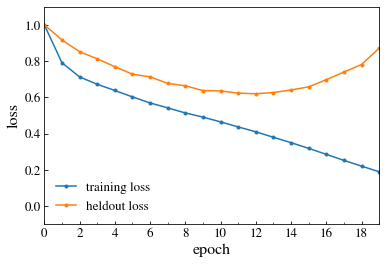

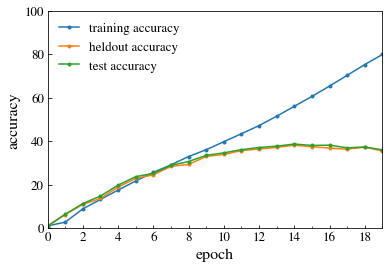

In [11]:
import matplotlib as mpl
import matplotlib.ticker as ticker
mpl.rcParams.update({
    'font.family' : 'STIXGeneral',
    'mathtext.fontset' : 'stix',
    'xtick.direction' : 'in' ,
    'xtick.labelsize' : 13 ,
    'xtick.top' : False ,
    'ytick.direction' : 'in' ,
    'ytick.labelsize' : 13 ,
    'ytick.right' : False ,
    'axes.labelsize' : 16,
    'legend.frameon' : False,
    'legend.fontsize' : 13,
    'legend.handlelength' : 1.5,
    'savefig.dpi' : 600, 
    'savefig.bbox' : 'tight'
})

plt.plot(tr_loss/tr_loss[0], '.-', label='training loss')
plt.plot(vl_loss/vl_loss[0], '.-', label='heldout loss')
plt.legend()
plt.ylim(-0.1, 1.1)
plt.xlim(0, 19)
plt.xlabel('epoch')
plt.ylabel('loss')
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(2))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
plt.savefig('vgg2_loss.png')
plt.show()


plt.plot(tr_accy/400, '.-', label='training accuracy')
plt.plot(vl_accy/100, '.-', label='heldout accuracy')
plt.plot(ts_accy/100, '.-', label='test accuracy')
plt.ylim(0, 100)
plt.xlim(0, 19)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(2))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
plt.savefig('vgg2_acc.png')
plt.show()

In [12]:
def pred_img(num):
    im_dir = './dataset/'
    plt.imshow(img.imread(im_dir+ts_x[num]))
    plt.show()
    test_x = np.array([img.imread(im_dir+u).T for i,u in enumerate(ts_x[num:num+1])])
    test_x = torch.FloatTensor(test_x)
    print("real:", ts_y[num], "pred:", label[model.forward(test_x).argmax(axis=1)])
def correct_img():
    correct_ind = []
    im_dir = './dataset/'
    for i in range (10000):
        test_x = np.array([img.imread(im_dir+u).T for j,u in enumerate(ts_x[i:i+1])])
        test_x = torch.FloatTensor(test_x)
        test_y = ts_y[i]
        output = model.forward(test_x)
        if torch.argmax(output, axis=1)==torch.argmax(testy[i]):
            correct_ind.append(i)
    return correct_ind

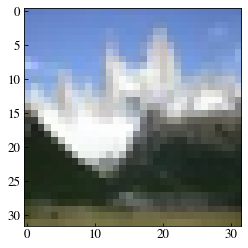

real: mountain pred: mountain


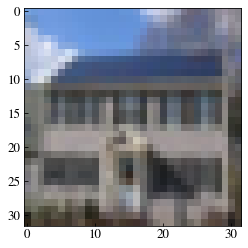

real: house pred: house


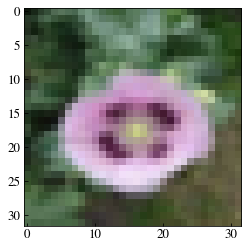

real: poppy pred: poppy


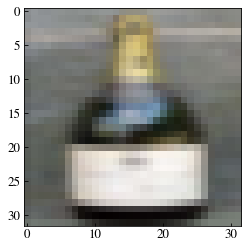

real: bottle pred: bottle


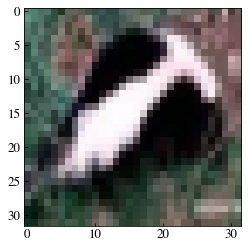

real: skunk pred: skunk


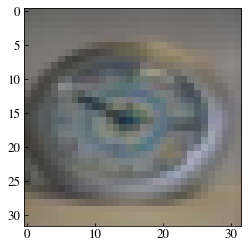

real: clock pred: clock


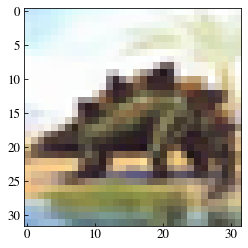

real: dinosaur pred: dinosaur


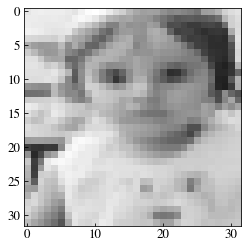

real: girl pred: girl


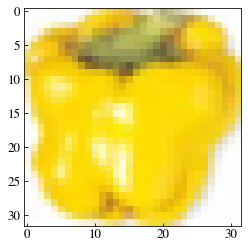

real: sweet_pepper pred: sweet_pepper


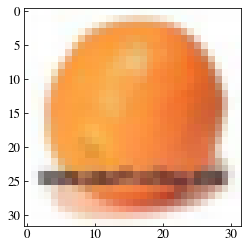

real: orange pred: orange


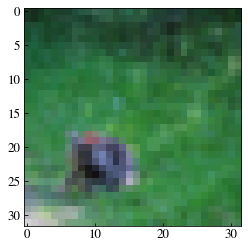

real: rabbit pred: rabbit


In [13]:
correct_ind = correct_img()
n=0
num=10
np.random.shuffle(correct_ind)
for i in correct_ind:
    plt.imshow(img.imread(im_dir+ts_x[i]))
    plt.show()
    test_x = np.array([img.imread(im_dir+u).T for j,u in enumerate(ts_x[i:i+1])])
    test_x = torch.FloatTensor(test_x)
    test_y = ts_y[i]
    print("real:", test_y, "pred:", label[model.forward(test_x).argmax(axis=1)])
    n+=1
    if n>num: break

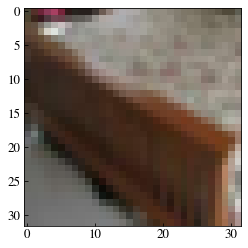

real: bed pred: otter


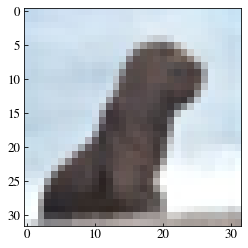

real: seal pred: beaver


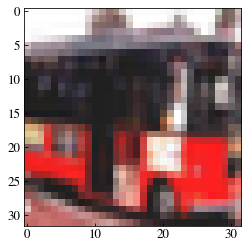

real: streetcar pred: bus


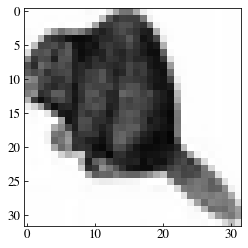

real: beaver pred: beaver


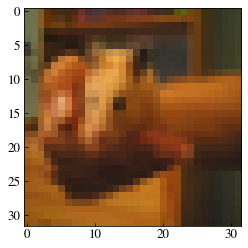

real: hamster pred: hamster


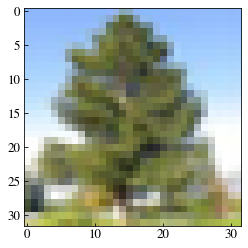

real: pine_tree pred: pine_tree


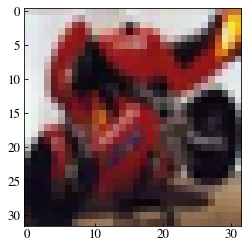

real: motorcycle pred: motorcycle


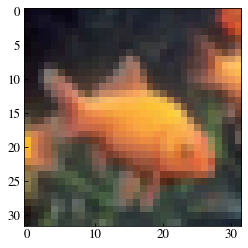

real: aquarium_fish pred: aquarium_fish


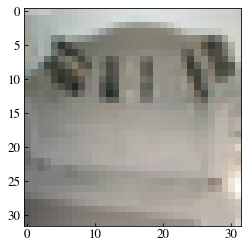

real: couch pred: cup


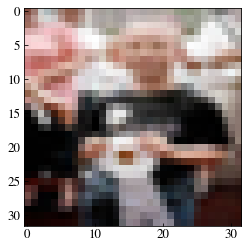

real: boy pred: woman


In [14]:
n=0
for i in np.random.randint(0, 10000, 10):
    plt.imshow(img.imread(im_dir+ts_x[i]))
    plt.show()
    test_x = np.array([img.imread(im_dir+u).T for j,u in enumerate(ts_x[i:i+1])])
    test_x = torch.FloatTensor(test_x)
    test_y = ts_y[i]
    print("real:", test_y, "pred:", label[model.forward(test_x).argmax(axis=1)])

In [15]:
a = []
b = []
for i in range(10000):
    #plt.imshow(img.imread(im_dir+ts_x[i]))
    #plt.show()
    a.append(ts_x[i])
    test_x = np.array([img.imread(im_dir+u).T for j,u in enumerate(ts_x[i:i+1])])
    test_x = torch.FloatTensor(test_x)
    b.append(label[model.forward(test_x).argmax(axis=1)])
a = np.array(a)
b = np.array(b)
np.savetxt('cifar100pred_vgg2.csv', np.array([a, b]).T, fmt='%s', delimiter=',',\
          header='id,category')